In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re,sys
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
PassengerId = test['PassengerId']

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
def process_data(d):
    #新特征
    d['FamilySize'] = d['SibSp'] + d['Parch'] + 1
    d[ 'IsAlone'] = 0
    d.loc[d['FamilySize'] == 1,'IsAlone'] = 1
    #众数填充缺失
    d.Embarked[ d.Embarked.isnull() ] = d.Embarked.dropna().mode().values
    #提取头衔，填充年龄缺失
    d['Title'] = d['Name'].map(lambda x : str(x).split('.')[0].split(',')[1])
    title = d['Title'].unique()
    median_age = np.zeros(len(title))
    for i in range(len(title)):
        median_age[i] = d[d['Title'] == title[i]]['Age'].dropna().median()
    for i in range(len(title)):
        d.loc[(d.Age.isnull()) & (d['Title']== title[i]),'Age']= median_age[i]

    d['Title'] = d['Title'].replace([" Melkebeke", " Countess", " Capt", " the Countess", " Col", " Don",
                                               " Dr", " Major", " Rev", " Sir", " Jonkheer", " Dona"], " Lamped")
    d["Title"] = d["Title"].replace([" Lady", " Mlle", " Ms", " Mme"], " Miss")
    
#     temp = d[['Title', 'Survived']].groupby(['Title'], as_index = False).count().sort_values(by = 'Survived', ascending = False)

    #众数填充缺失
    d.Fare[d.Fare.isnull()] = d.Fare.dropna().mode().values
    #将连续数值分区间
    d['FareBins'] = pd.qcut(d['Fare'],5)
    d['AgeBins'] = pd.cut(d['Age'],[0,12,20,30,50,200])
    #one-hot编码
    d_farebin = pd.get_dummies(d['FareBins'],prefix='FareBins')
    d_embark = pd.get_dummies(d['Embarked'],prefix='Embarked')
    d_age = pd.get_dummies(d['AgeBins'],prefix='AgeBins')
    d_name = pd.get_dummies(d['Title'],prefix='Title')
    d['Sex'] = d['Sex'].map({'female': 1, 'male': 0}).astype(int)
    #合并，删除
    d = pd.concat([d, d_farebin,d_embark,d_age,d_name], axis=1)
    d.drop(['Embarked','FareBins','AgeBins','Fare','Age','Title','Name','SibSp','Parch','Ticket','Cabin','PassengerId'], axis=1, inplace=True)
    return d
    

In [7]:
train = process_data(train)
test = process_data(test)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 23 columns):
Survived                      891 non-null int64
Pclass                        891 non-null int64
Sex                           891 non-null int64
FamilySize                    891 non-null int64
IsAlone                       891 non-null int64
FareBins_(-0.001, 7.854]      891 non-null uint8
FareBins_(7.854, 10.5]        891 non-null uint8
FareBins_(10.5, 21.679]       891 non-null uint8
FareBins_(21.679, 39.688]     891 non-null uint8
FareBins_(39.688, 512.329]    891 non-null uint8
Embarked_C                    891 non-null uint8
Embarked_Q                    891 non-null uint8
Embarked_S                    891 non-null uint8
AgeBins_(0, 12]               891 non-null uint8
AgeBins_(12, 20]              891 non-null uint8
AgeBins_(20, 30]              891 non-null uint8
AgeBins_(30, 50]              891 non-null uint8
AgeBins_(50, 200]             891 non-null uint8
Title_ Lamped

In [9]:
def show_correlation(d):
    #相关矩阵
    corrDf = d.corr() 
    print corrDf['Survived'].sort_values(ascending =False)
    colormap = plt.cm.RdBu
    plt.figure(figsize=(14,12))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    sns.heatmap(d.astype(float).corr(),linewidths=0.1,vmax=1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True)

Survived                      1.000000
Sex                           0.543351
Title_ Miss                   0.341294
Title_ Mrs                    0.339040
FareBins_(39.688, 512.329]    0.263421
Embarked_C                    0.168240
AgeBins_(0, 12]               0.117636
Title_ Master                 0.085221
AgeBins_(30, 50]              0.084296
FareBins_(21.679, 39.688]     0.062704
FareBins_(10.5, 21.679]       0.040812
FamilySize                    0.016639
Embarked_Q                    0.003650
AgeBins_(12, 20]             -0.001559
Title_ Lamped                -0.021481
AgeBins_(50, 200]            -0.022932
AgeBins_(20, 30]             -0.129411
Embarked_S                   -0.149683
FareBins_(-0.001, 7.854]     -0.171109
FareBins_(7.854, 10.5]       -0.191707
IsAlone                      -0.203367
Pclass                       -0.338481
Title_ Mr                    -0.549199
Name: Survived, dtype: float64


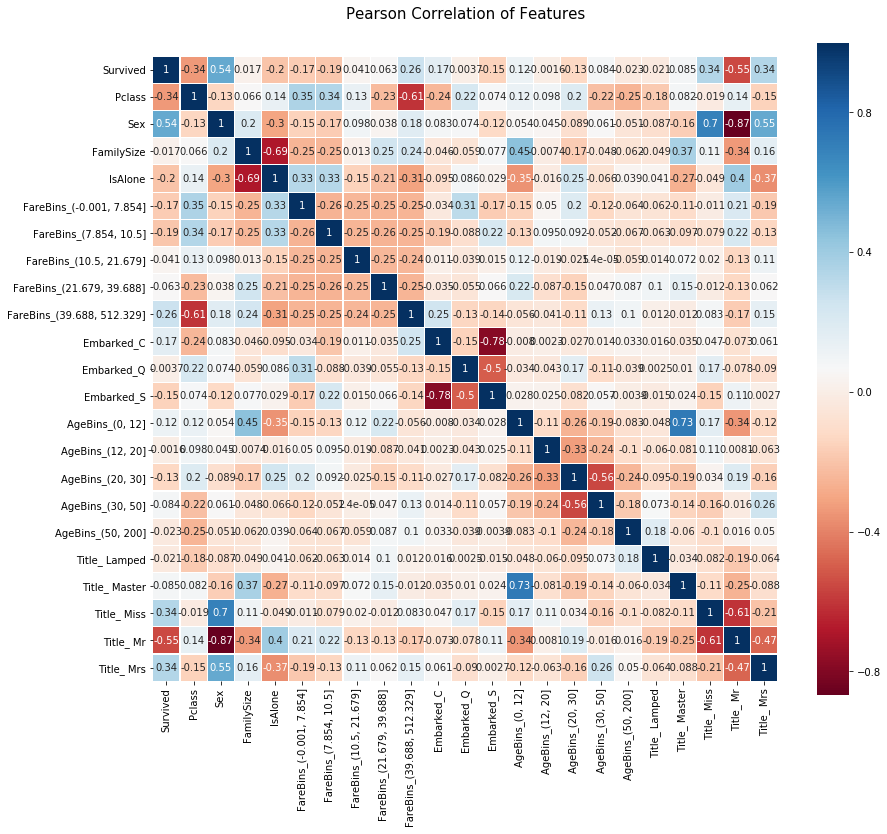

In [10]:
show_correlation(train)

In [11]:
# from sklearn import cross_validation
# cross_validation.cross_val_score(lr,train_data[0::,1::],train_data[0::,0],cv=5,scoring='precision')

In [12]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

In [13]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [14]:
    rf_params = {
        'n_jobs': -1,
        'n_estimators': 500,
         'warm_start': True, 
         #'max_features': 0.2,
        'max_depth': 6,
        'min_samples_leaf': 2,
        'max_features' : 'sqrt',
        'verbose': 0
    }

    # Extra Trees Parameters
    et_params = {
        'n_jobs': -1,
        'n_estimators':500,
        #'max_features': 0.5,
        'max_depth': 8,
        'min_samples_leaf': 2,
        'verbose': 0
    }

    # AdaBoost parameters
    ada_params = {
        'n_estimators': 500,
        'learning_rate' : 0.75
    }

    # Gradient Boosting parameters
    gb_params = {
        'n_estimators': 500,
         #'max_features': 0.2,
        'max_depth': 5,
        'min_samples_leaf': 2,
        'verbose': 0
    }

    # Support Vector Classifier parameters 
    svc_params = {
        'kernel' : 'linear',
        'C' : 0.025
        }

In [15]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [16]:

# train.values[:,0]
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [17]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

In [18]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.13487175 0.17744123 0.07665852 0.02203161 0.01872306 0.01569528
 0.01340397 0.01766554 0.0502723  0.02068853 0.00700373 0.01565101
 0.01712073 0.0051206  0.01407512 0.0122585  0.0053147  0.01054688
 0.01515361 0.06450493 0.22529326 0.06050514]
[0.12517938 0.18451728 0.04695407 0.02102497 0.01395018 0.01515285
 0.01639098 0.02004595 0.04133975 0.01574243 0.00924731 0.01633356
 0.01974947 0.00577665 0.01102035 0.0139256  0.00647351 0.00914165
 0.0123373  0.0843044  0.24498514 0.06640721]
[0.018 0.286 0.074 0.018 0.008 0.004 0.002 0.016 0.024 0.002 0.006 0.004
 0.01  0.01  0.002 0.004 0.008 0.062 0.068 0.106 0.178 0.09 ]
[0.11312983 0.02690419 0.14530463 0.04640048 0.03010495 0.05842976
 0.06918935 0.04564889 0.02497081 0.0556801  0.02379958 0.03406675
 0.01425736 0.03737503 0.0457248  0.06637983 0.02455253 0.00742584
 0.00395046 0.04781447 0.0529171  0.02597327]


In [19]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [20]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [21]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [22]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)